# LOAD Modules

In [1]:
%matplotlib inline
#%matplotlib widget
%load_ext autoreload
%autoreload 2


import numpy as np
from visualisations import eeg_sample_plot, events_distribution_plot, curve_name_gen
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from datasets import ChannelsVoltageDataset
from neural_nets.nn_models_getter import get_nn_model
from optimizers import get_optimizer
from utils_train import fit, test, plot_all_metrics, plot_val_metrics, final_test_acc
from configs import configs_ozhan, configs_tim, configs_joaquin
from data_loader_creation import get_dataloader_objects
from classification_results import results_storer

# Select the configuration

In [2]:
""" USER: SELECT THE CONFIGURATION YOU NEED """
#myList = configs_tim.list_of_configs
#myList = configs_joaquin.list_of_configs
myList = configs_ozhan.list_of_configs

# Train

ConvNetOzhan3D_Adam 
-------------------------

We are not on the cluster...

Data is being loaded using MNE...


100%|██████████| 1/1 [00:14<00:00, 14.34s/it]


2700 matching events found
No baseline correction applied
...data loading with MNE was finished. 

320  time samples and  64  EEG channels for one epoch are taken.  Total epoch number is  2700  and there are  60  subjects included.
 There are in total  2  classes for classification.


Expected network layer output shapes:
Input: [1, 8, 8, 320]
Layer 1 Out: [32, 8, 8, 54]
Layer 2 Out: [128, 8, 8, 27]
Layer 3 Out: [128, 1, 1, 14]
Linear Layer Features: 1792 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.0001 

-> Epoch 1/200: train_loss: 0.7239, train_accuracy: 49.1998%, val_loss: 0.6929, val_accuracy: 51.0288%
-> Epoch 2/200: train_loss: 0.7000, train_accuracy: 56.1500%, val_loss: 0.6924, val_accuracy: 49.7942%
-> Epoch 3/200: train_loss: 0.6897, train_accuracy: 58.0704%, val_loss: 0.6915, val_accuracy: 49.7942%
-> Epoch 4/200: train_loss: 0.6516, train_accuracy: 62.4600%, val_loss: 0.6901, val_accuracy: 49.7942%
-> Epoch 5/200: train_los

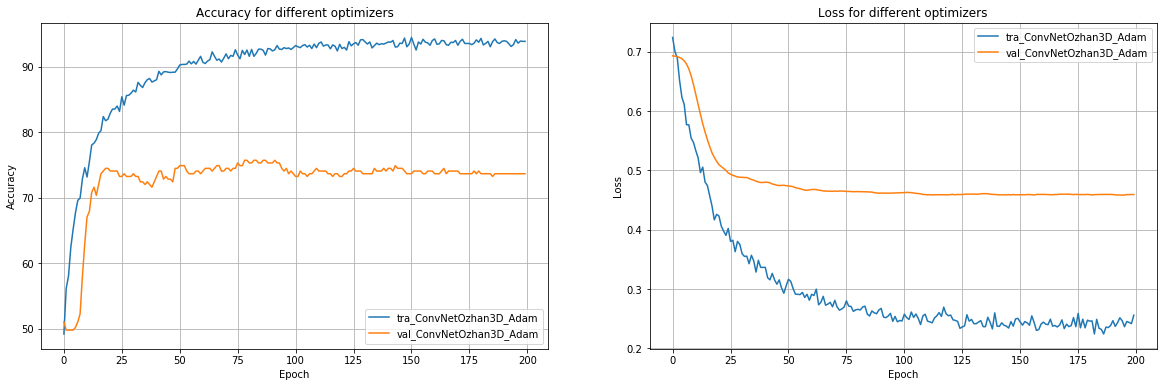

In [3]:
training_curves = {}

for my_cfg in myList:
    
    curve_name_gen(my_cfg)
    
    """ PREPARE DATALOADERS """
    train_dl, val_dl, test_dl, input_dimension_, output_dimension_ = get_dataloader_objects(my_cfg)

    
    """CLASSIFICATION"""
    # Get the model
    model_untrained = get_nn_model(my_cfg, input_dimension=input_dimension_,output_dimension=output_dimension_)

    # Get the optimizer
    optimizer = get_optimizer(my_cfg, model_untrained.parameters())

    # Train and show validation loss
    train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s =\
        fit(train_dl, val_dl, model_untrained, optimizer, my_cfg)
    
    curves = train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s
    training_curves[my_cfg.curve_name] = curves
    
    # Report final accuracy
    test_loss, test_accuracy =  final_test_acc(model_trained, test_dl, my_cfg)


    # Store the results
    results_storer.store_results_for_plot(my_cfg,test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies)

    results_storer.store_results(my_cfg, model_trained, optimizer, test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies, test_dl)


plot_all_metrics(training_curves)